In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings

# read the data
data = pd.read_csv('Data/fraud_data.csv')

# Suppress warnings
warnings.filterwarnings("ignore")

data

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
0,04-01-2019 00:58,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a3806e984cec6ac0096d8184c64ad3a1,65.654142,-164.722603,1
1,04-01-2019 15:06,Predovic Inc,shopping_net,966.11,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a59185fe1b9ccf21323f581d7477573f,65.468863,-165.473127,1
2,04-01-2019 22:37,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,86ba3a888b42cd3925881fa34177b4e0,65.347667,-165.914542,1
3,04-01-2019 23:06,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,3a068fe1d856f0ecedbed33e4b5f4496,64.445035,-166.080207,1
4,04-01-2019 23:59,Friesen Lt,health_fitness,18.17,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,891cdd1191028759dc20dc224347a0ff,65.447094,-165.446843,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14441,22-01-2019 00:37,Hudson-Grady,shopping_pos,122.00,Athena,OR,45.8289,-118.4971,1302,Dealer,18-10-1976,699a4c06b22711bf3e0d8ef91232d356,46.442439,-118.524214,0
14442,22-01-2019 00:41,"""Nienow, Ankunding and Collie""",misc_pos,9.07,Gardiner,OR,43.7857,-124.1437,260,"""Engineer, maintenance""",01-09-1956,080d620d24815c7d6c637cf0b71dde8e,42.901265,-124.995317,0
14443,22-01-2019 00:42,Pacocha-O'Reilly,grocery_pos,104.84,Alva,WY,44.6873,-104.4414,110,"""Administrator, local government""",16-05-1973,3c346c8cd627c5fe3ed57430db2e9ae7,45.538062,-104.542117,0
14444,22-01-2019 00:48,"""Bins, Balistreri and Beatty""",shopping_pos,268.16,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,e66ffcc95ba7fc490486242af1205d04,64.081462,-165.898698,0


In [2]:
#Oops! The data somehow is not cleaned properly. Let's clean it first.
# drop the rows with missing values
data = data.dropna()

#Make sure is_fraud is a binary variable. Remove those that aren't 0 or 1

data = data[(data["is_fraud"] == "0") | (data["is_fraud"] == "1")]

data["is_fraud"] = data["is_fraud"].astype(int)

data["is_fraud"].unique()

array([1, 0])

In [3]:
### YOUR CODE STARTS HERE
# Features and target variable
X = data[['lat', 'long', 'amt', 'city_pop', 'merch_lat', 'merch_long']]
y = data['is_fraud'].astype(int)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
### YOUR CODE ENDS HERE



X_train shape: (11555, 6)
X_test shape: (2889, 6)
y_train shape: (11555,)
y_test shape: (2889,)


In [4]:
### YOUR CODE STARTS HERE
# Initialize the scaler object
scaler = StandardScaler()

# Scale the training data
X_train_scaled = scaler.fit_transform(X_train)

# Scale the test data
X_test_scaled = scaler.fit_transform(X_test)
### YOUR CODE ENDS HERE



In [5]:
# Define the values for n_neighbors to be tested
n_neighbors_list = [1, 3, 5, 10, 50, 100, 110]
best_r2 = -float('inf')
best_k = None

# Iterate over each value of n_neighbors
for k in n_neighbors_list:

    # Create and train the KNN
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = knn.predict(X_test_scaled)
    
    # Calculate the R^2 score
    r2 = r2_score(y_test, y_pred)
    
    # Print the R^2 score for the current value of n_neighbors
    print(f"n_neighbors: {k}, R^2 Score: {r2:.2f}")

n_neighbors: 1, R^2 Score: 0.35
n_neighbors: 3, R^2 Score: 0.53
n_neighbors: 5, R^2 Score: 0.56
n_neighbors: 10, R^2 Score: 0.59
n_neighbors: 50, R^2 Score: 0.55
n_neighbors: 100, R^2 Score: 0.52
n_neighbors: 110, R^2 Score: 0.51


In [6]:
# Set the best k value found from the previous test
best_k = 10

# Initialize the K-Nearest Neighbors Regressor with the best k value
best_model = KNeighborsRegressor(n_neighbors=best_k)

# Fit the model using the scaled training data
best_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data using the trained KNN model
y_pred = best_model.predict(X_test_scaled)

# Calculate the Mean Squared Error (MSE) between the predicted and actual values
mse_knn = mean_squared_error(y_test, y_pred)

# Calculate the R^2 score for the model
r2_knn = r2_score(y_test, y_pred)

# Print the MSE and R^2 score rounded to 2 decimal places
print(f"Mean Squared Error: {mse_knn:,.2f}")
print(f"R^2 Score: {r2_knn:.2f}")

Mean Squared Error: 0.05
R^2 Score: 0.59


Mean Squared Error (MSE): 0.07
R² Score: 0.36


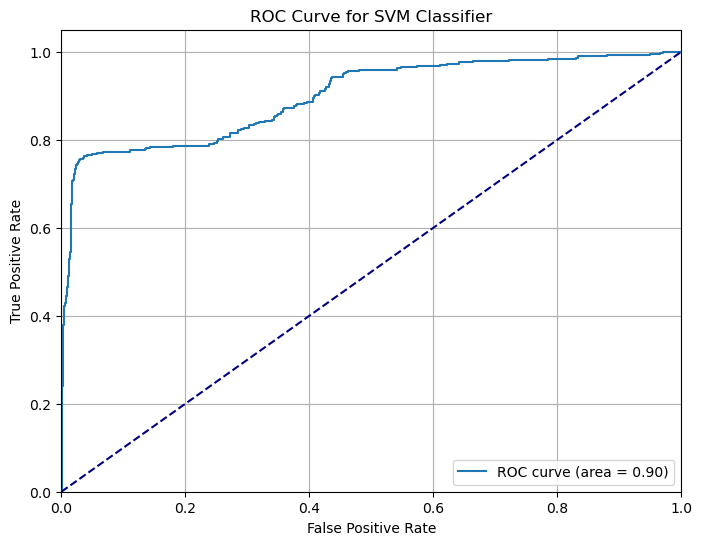

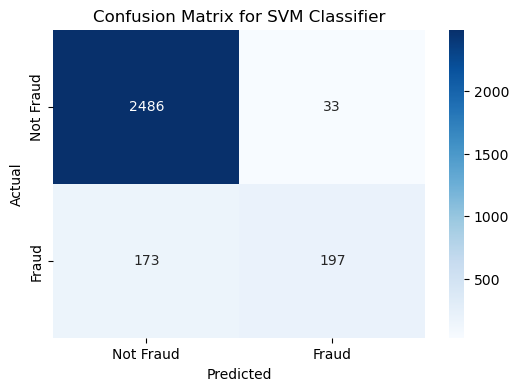

In [12]:
# using the svm method on the data now
from sklearn import svm
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

clf = svm.SVC()
# Fit the SVM model using the scaled training data
clf.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
y_pred_svm = clf.predict(X_test_scaled)

# Calculate MSE
mse_svm = mean_squared_error(y_test, y_pred_svm)
print(f"Mean Squared Error (MSE): {mse_svm:.2f}")

# Calculate R² score
r2_svm = r2_score(y_test, y_pred_svm)
print(f"R² Score: {r2_svm:.2f}")

# Get probability estimates from the SVM model (use `decision_function` for SVMs)
y_prob_svm = clf.decision_function(X_test_scaled)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_svm)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix for SVM Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [44]:
# ### YOUR CODE STARTS HERE
# # Store scatter plot and line plot data in a dictionary
# scatter_data = {
#     'Actual Prices': y_test,
#     'Predicted Prices': y_pred
# }

# # Define the average house features
# avg_house = np.array([[1200, 2, 1]])

# # Scale the average house data
# avg_house_scaled = scaler.transform(avg_house)

# # Predict the price using the trained K-Nearest Neighbors Regressor
# predicted_price = best_model.predict(avg_house_scaled)

# # Extract the value from the ndarray
# predicted_price_value = predicted_price[0]

# # Prepare line plot data to visualize a reference line for predicted vs actual prices
# line_plot_data = {
#     'x': [min(y_test), max(y_test)],
#     'y': [min(y_test), max(y_test)]
# }

# # Output the predicted price

# print(f"Predicted Price: ${predicted_price_value:,.2f}")

# # Create a figure for plotting and display it
# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_pred, color='#FF8200', label='Predicted vs Actual')
# plt.scatter(predicted_price_value, predicted_price_value, color='#4B4B4B')

# plt.plot(line_plot_data['x'], line_plot_data['y'], color='#4B4B4B', linestyle='--')
# plt.title("K-Nearest Neighbors: Predicted vs Actual House Prices")
# plt.xlabel("Actual House Prices")
# plt.ylabel("Predicted House Prices")

# plt.figtext(0, 1, f"Predicted price: ${predicted_price_value:,.2f}", fontsize=10, ha='left')

# # Set the formatter to display plain numbers without scientific notation
# # plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
# # plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

# # Set x and y marks to be in scientific notation to 1 decimal, to match the expected output (idk what this overwrites. I just used internet results to try and match the single decimal form from the expected output)
# plt.ticklabel_format(style='sci', axis='both', scilimits=(0, 0))

# plt.legend()
# plt.show()

ValueError: X has 3 features, but StandardScaler is expecting 6 features as input.